# Initial study

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Scherfler, Christoph, et al. <a href=https://onlinelibrary.wiley.com/doi/pdf/10.1002/ana.22245>White and gray matter abnormalities in idiopathic rapid eye movement sleep behavior disorder: a diffusion‐tensor imaging and voxel‐based morphometry study.</a> Annals of neurology 69.2 (2011): 400-407. 
</div>

This study recruited 34 patients with iRBD and confirmed iRBD diagnosis with polysomnography (PSG). Patients had no PD or dementia at time of MRI. The demographics parameters were as follows (table extracted from the paper):

<img src="demographics.png"/>

In [1]:
from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>"""
)

In [2]:
import datetime

print(f"This notebook was run on {datetime.datetime.now()}")

This notebook was run on 2022-07-13 13:10:01.966786


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
%%capture null
!PIP_REQUIRE_VIRTUALENV=0  pip install -r requirements.txt

# PPMI cohort preparation

## Metadata download

Let's download the required metadata files from PPMI: 
* Age at visit
* Demographics (to retrieve sex)
* REM Sleep Behavior Disorder Questionnaire

You will need to enter your PPMI username and password.

In [5]:
import os
import os.path as op
import ppmi_downloader

data_dir = "data"
required_files = [
    "Age_at_visit.csv",
    "Demographics.csv",
    "REM_Sleep_Behavior_Disorder_Questionnaire.csv",
]

missing_files = [x for x in required_files if not op.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    print(f"Downloading missing files: {missing_files}")
    ppmi = ppmi_downloader.PPMIDownloader()
    ppmi.download_metadata(
        missing_files, destination_dir=data_dir, headless=False, timeout=600
    )

print(f"The following files are available: {required_files}")

The following files are available: ['Age_at_visit.csv', 'Demographics.csv', 'REM_Sleep_Behavior_Disorder_Questionnaire.csv']


We will also need file `MRI_info.csv` produced by notebook https://github.com/LivingPark-MRI/ppmi-MRI-metadata. This file contains aggregate information about T1-weighted MRIs usable for VBM. 

In [6]:
file_path = op.join("data", "MRI_info.csv")
if not op.exists(file_path):
    !(cd data && python -m wget "https://raw.githubusercontent.com/LivingPark-MRI/ppmi-MRI-metadata/main/MRI metadata.ipynb")  # use requests to improve portability
    npath = op.join("data", "MRI metadata.ipynb")
    %run "{npath}"
print(f"File {file_path} is available")

File data/MRI_info.csv is available


## RBD Score computation

The original study used polysomnographies to diagnose REM Sleep Behavior Disorder, however, this data is not available in PPMI.
Instead, we will use the REM Sleep Behavior Disorder Screening Questionnaire [[1]](https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mds.21740) to discriminate RBD patients from controls. This questionnaire consists of 13 yes/no questions that are aggregated to produce an RBD score on a scale of 13 points. 

We obtain the following distribution of RBD scores in the PPMI dataset:

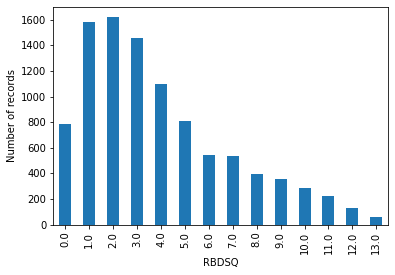

In [7]:
# Load PPMI RSBDQ data
import pandas as pd

df = pd.read_csv(op.join("data", "REM_Sleep_Behavior_Disorder_Questionnaire.csv"))

# Compute and add RBDSQ score
df["RBDSQ"] = (
    df["DRMVIVID"]  # Q1
    + df["DRMAGRAC"]  # Q2
    + df["DRMNOCTB"]  # Q3
    + df["SLPLMBMV"]  # Q4
    + df["SLPINJUR"]  # Q5
    + df["DRMVERBL"]  # Q6.1
    + df["DRMFIGHT"]  # Q6.2
    + df["DRMUMV"]  # Q6.3
    + df["DRMOBJFL"]  # Q6.4
    + df["MVAWAKEN"]  # Q7
    + df["DRMREMEM"]  # Q8
    + df["SLPDSTRB"]  # Q9
    + df[  # Q10
        [
            "BRNINFM",
            "DEPRS",
            "EPILEPSY",
            "HETRA",
            "NARCLPSY",
            "PARKISM",
            "RLS",
            "STROKE",
        ]
    ].max(axis=1)
)

df["Q6"] = df["DRMVERBL"] + df["DRMFIGHT"] + df["DRMUMV"] + df["DRMOBJFL"]

# Note: CNSOTHCM isn't present in data

# Check that max RBDSQ score is <= 13
assert df["RBDSQ"].max() <= 13

df.groupby("RBDSQ").count()["REC_ID"].plot.bar()

from matplotlib import pyplot as plt

plt.ylabel("Number of records")
plt.show()

## Filters

Consistently with the original study, we only include subjects with no Parkinsonism. We include subjects in the RBD group when their RBD score is >= 5. We include subjects in the control group when their RBD score is < 5 and their score to Question 6 of the RBD Screening Questionnaire is 0 [**TODO** ref needed, see email thread between Madeleine and Ron Postuma].

We obtain the following group sizes:

<!-- and a cutoff score of 6 to identify RBD subjects among PD subjects, consistently with the results presented in [[2]](https://www.sciencedirect.com# /science/article/pii/S138994571100164X). -->

In [8]:
# Read demographics and MRI data.
mri = pd.read_csv(op.join("data", "MRI_info.csv"))[
    ["Subject ID", "Visit code", "Description"]
]
mri.rename(columns={"Subject ID": "PATNO", "Visit code": "EVENT_ID"}, inplace=True)
dem = pd.read_csv(op.join("data", "Demographics.csv"))[["PATNO", "SEX"]]
age = pd.read_csv(op.join("data", "Age_at_visit.csv"))

# Merge RBD data with demographics, age and MRI
merged = (
    df.merge(dem, on="PATNO", how="inner")
    .merge(age, on=["PATNO", "EVENT_ID"], how="inner")
    .merge(mri, on=["PATNO", "EVENT_ID"], how="inner")[
        ["PATNO", "RBDSQ", "Q6", "SEX", "AGE_AT_VISIT", "Description"]
    ]
)

# Extract RBD subjects and controls according to inclusion criteria
rbds = merged[merged["RBDSQ"] >= 5].sort_values(by="PATNO")
controls = merged[(merged["RBDSQ"] < 5) & (merged["Q6"] == 0)].sort_values(by="PATNO")

print(f"Number of RBD subjects: {len(rbds)}")
print(f"Number of control subjects: {len(controls)}")

Number of RBD subjects: 742
Number of control subjects: 1045


## Cohort matching

The RBD and control groups built previously give us a lot of flexibility to build a cohort that matches the one in the original study. We adopted the following approach:
1. Randomly select 4 control women and 10 control men, to reproduce the F/M balance in the original paper
2. Find 26 subjects from the RBD group that best match age and sex in the control group. We matched sex by direct sampling of males and females using the same proportion as in the original study. We matched age using a nearest-neighbor approach.

We obtain the following cohort:

In [9]:
def nn_match(sample1, df_2, n2, cat_variables, num_variables, random_state=0):
    """
    Find len(sample1) rows in df_2 such that variables are matched with sample1.

    sample1: samples in group1
    df_2: dataframe with subjects in group 2
    n2: desired sample size for group 2
    cat_variables: categorical variables to match
    num_variables: numerical variables to match
    """

    def nn(x, df, variables):
        """
        Find index of nearest neighbor of x in df

        * x: a dataframe row
        * df: a dataframe
        * variables: variables to match. Should be normalized.
        """
        df["dist"] = sum((df[var] - x[var]) ** 2 for var in variables)
        df.sort_values("dist", inplace=True)
        return df.head(1).index[
            0
        ]  ## there's probably a better way to do it but it works

    # Check assumptions
    n1 = len(sample1)
    assert n1 <= n2
    for v in num_variables + cat_variables:
        assert v in sample1 and v in df_2

    # Copy original dataframe to leave them untouched
    df_2_ = df_2.copy()
    sample1_ = sample1.copy()

    # Normalize variables to match to compute meaningful distances
    for v in num_variables:
        m = df_2_[v].mean()
        s = df_2_[v].std()
        for df in (df_2_, sample1_):
            df[v] = (df[v] - m) / s

    # For each subject in sampled group 1,
    # find one or more subject in sampled group 2, without replacement.
    indices = []
    for i in range(n2):
        j = i % n1  # loop over sample1
        df_2_cat = df_2_.copy()
        for c in cat_variables:
            df_2_cat = df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]
        assert len(df_2_cat) > 0
        index = nn(sample1_.iloc[j], df_2_cat, num_variables)
        df_2_.drop(index=index, inplace=True)
        indices.append(index)

    sample2 = df_2[df_2.index.isin(indices)]

    return sample2

In [10]:
# Randomly select 4 control women and 10 control men, to reproduce F/M balance in original paper
controls = pd.concat(
    [
        controls[controls["SEX"] == 0].sample(n=4, random_state=1),
        controls[controls["SEX"] == 1].sample(n=10, random_state=1),
    ]
)

# Match with RBD subjects
rbds = nn_match(controls, rbds, 26, ["SEX"], ["AGE_AT_VISIT"], random_state=1)

In [11]:
import os

print(
    "\t\t\t| iRBD Patients\t| Controls"
    + os.linesep
    + f"Subjects, No. \t\t| {len(rbds)} \t\t| {len(controls)}"
    + os.linesep
    + f"F/M, No. \t\t| {len(rbds[rbds['SEX']==0])}/{len(rbds[rbds['SEX']==1])} \t\t| {len(controls[controls['SEX']==0])}/{len(controls[controls['SEX']==1])}"
    + os.linesep
    + f"Age, mean +/- SD \t| {round(rbds['AGE_AT_VISIT'].mean(),1)} +/- {round(rbds['AGE_AT_VISIT'].std(),1)} \t| {round(controls['AGE_AT_VISIT'].mean(),1)} +/- {round(controls['AGE_AT_VISIT'].std(),1)}"
)

			| iRBD Patients	| Controls
Subjects, No. 		| 26 		| 14
F/M, No. 		| 8/18 		| 4/10
Age, mean +/- SD 	| 62.0 +/- 10.9 	| 62.2 +/- 10.8


The demographics parameters of the selected PPMI subjects seem comparable to the ones in the initial study. By construction, gender balance is better in our cohort than in the original study.

In [12]:
# Save patient ids
pd.concat([controls["PATNO"], rbds["PATNO"]]).to_csv(
    "scherfler-etal-patnos.csv", index=False
)

# Image analysis

Structural MRI analysis in the original paper is a straightforward VBM analysis implemented with SPM using the DARTEL toolbox. An excellent tutorial on VBM in SPM is available in https://www.fil.ion.ucl.ac.uk/~john/misc/VBMclass15.pdf

## Imaging data download

First, let's download or update the DataLad dataset associated with this paper. This dataset contains:
* MRI data for the selected subjects
* Pre-computed analysis results
LivingPark DataLad datasets are currently stored on `login.bic.mni.mcgill.ca`. This notebook assumes that you can ssh to this server and that you have configured DataLad in your account (see instructions [here](https://docs.google.com/document/d/1K7RzQjYC1O6tpSqe_c0CvxvJq38J10zNrDIdw20Yh_0/edit?usp=sharing)). 

In [13]:
import datalad
import datalad.api as dat
import os.path as op
import io
from contextlib import redirect_stdout, redirect_stderr

# Download datalad dataset
datalad_path = ".datalad"  # local dataset name
user = "glatard"  # username on login.bic.mni.mcgill.ca
if op.exists(datalad_path):
    d = dat.Dataset(datalad_path)
    d.update(how="merge")
else:
    dat.install(
        source=f"{user}@login.bic.mni.mcgill.ca:/data/pd/ppmi/livingpark-papers/scherfler-etal",
        path=datalad_path,
    )

[INFO] Fetching updates for Dataset(/home/glatard/code/livingpark/scherfler-etal/.datalad) 


merge(ok): . (dataset) [Merged origin/master]
update.annex_merge(ok): . (dataset) [Merged annex branch]
update(ok): . (dataset)
action summary:
  merge (ok: 1)
  update (ok: 1)
  update.annex_merge (ok: 1)


We then check if the subjects selected in our cohort are available in the DataLad dataset:

In [14]:
dataset_name = "inputs"

subject_ids = list(controls.append(rbds)["PATNO"])
missing_subjects = [
    x for x in subject_ids if not op.exists(op.join(dataset_name, f"sub-{x}"))
]
available_subjects = list(set(subject_ids) - set(missing_subjects))
print(f"Number of available subjects: {len(sorted(available_subjects))}")
print(f"Number of missing subjects: {len(sorted(missing_subjects))}")

Number of available subjects: 2
Number of missing subjects: 38


**TODO** In the future we will download the missing subjects, convert them to BIDS, and add them to DataLad dataset. For now we will just proceed with the available subjects.

In [15]:
# # Download missing subjects
# import ppmi_downloader

# ppmi = ppmi_downloader.PPMIDownloader()
# ppmi.download_imaging_data(missing_subjects, headless=False, timeout=3600)

T1 images comes as .nii.gz files while SPM requires .nii files. Let's get the required images and uncompress them if not already done in the DataLad dataste:

In [16]:
import gzip
import shutil
import glob


def unzip(filename, output_filename):
    with gzip.open(filename, "rb") as f_in:
        os.makedirs(op.dirname(output_filename), exist_ok=True)
        with open(output_filename, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)


count = 0
for s in available_subjects:
    glob_expression = (
        f"{dataset_name}/sub-{s}/ses-1/anat/sub-{s}_ses-1_*run-01_T1w.nii.gz"
    )
    for file_name in glob.glob(glob_expression):
        output_filename = file_name.replace(".gz", "").replace(
            dataset_name, op.join("outputs", "data")
        )
        if not op.exists(output_filename):
            count += 1
            dat.get(file_name.replace(dataset_path, op.join(datalad_path, "inputs")))
            unzip(file_name, output_filename)  # to make it usable in SPM
print(
    f"Downloaded and uncompressed {count} T1 images (the other ones were already available in the DataLad dataset)"
)

Downloaded and uncompressed 0 T1 images (the other ones were already available in the DataLad dataset)


## Image processing

Image processing consists of:
1. Data pre-processing: segmentation, DARTEL template generation, normalization to MNI space
2. Intra-cranial volume computation (to be used as covariates in the statistical model)
3. Statistical model

We implemented each of these steps as an SPM batch. For each batch, we created a template where file names will be inserted. Batch templates are available in `code/templates`.

We generate a run id that uniquely identifies the cohort built previously. We will use this run id to avoid recomputing the same results multiple times.

In [17]:
run_id = str(hash(tuple(sorted(controls.append(rbds)["PATNO"])))).replace(
    "-", "_"
)  # - in filenames crash SPM (Matlab)
print(f"Run id: {run_id}")

Run id: 3071741767022442618


### Pre-processing

Let's parametrize the pre-processing batch template using the subjects in the cohort:

In [18]:
import tempfile


def write_batch_files(batch_job_filename, replaced_keys, tempfile_name):
    """
    tempfile_name: should end in _job.m
    """

    def replace_keys(string, replace_keys):
        for k in replace_keys:
            string = string.replace(k, replace_keys[k])
        return string

    # Batch job file
    with open(batch_job_filename, "r") as f:
        content = f.read()

    assert tempfile_name.endswith("_job.m")

    with open(tempfile_name, "w") as f:
        f.write(replace_keys(content, replaced_keys))

    print(f"Job batch file written in {op.basename(tempfile_name)}")

    # Batch file
    batch_file = op.join("code", "templates", "call_batch.m")
    tempfile_name_batch = tempfile_name.replace("_job", "_batch")

    with open(batch_file, "r") as f:
        content = f.read()

    with open(tempfile_name_batch, "w") as f:
        f.write(
            replace_keys(
                content,
                {
                    "[BATCH]": f"addpath('{op.join(os.getcwd(), 'code', 'batches')}')"
                    + os.linesep
                    + op.basename(tempfile_name.replace(".m", ""))
                },
            )
        )

    print(f"Batch file written in {op.basename(tempfile_name_batch)}")


def run_batch_file(job_filename):

    log_file_name = op.abspath(
        op.join("outputs", "logs", op.basename(job_filename.replace("_job.m", ".log")))
    )
    spm_batch_file = job_filename.replace("_job", "_batch")

    if op.exists(log_file_name):
        print(
            f"Log file {op.basename(log_file_name)} exists, skipping batch execution (remove file to force execution)"
        )
        return

    print(f"Log file {op.basename(log_file_name)} does not exist, running batch")

    dat.unlock(
        dataset=d
    )  # unlock the dataset so that results can be overwritten if necessary
    output = spm_batch(
        "launch", "-s", "-u", spm_batch_file=spm_batch_file, log_file_name=log_file_name
    )

    assert (
        output.exit_code == 0
    ), f"Execution error, inspect output object for logs: {output}"

    print(f"Execution was successful.")

    return output

In [19]:
import glob


def subject_T1(subject_id):
    expression = f"{op.join('outputs', 'data')}/sub-{subject_id}/ses-1/anat/sub-{subject_id}_ses-1_*run-01_T1w.nii"
    file_names = glob.glob(expression)
    assert (
        len(file_names) == 1
    ), f"Zero or more than 1 files were matched by expression: {expression}"
    return file_names[0]


# Preprocessing batch
preprocessing_batch_job = op.join("code", "templates", "pre_processing_job.m")
preprocessing_name = op.abspath(
    op.join("code", "batches", f"pre_processing_{run_id}_job.m")
)

image_files = sorted([f"'{op.abspath(subject_T1(s))},1'" for s in available_subjects])
write_batch_files(
    preprocessing_batch_job,
    {"[IMAGES]": os.linesep.join(image_files)},
    tempfile_name=preprocessing_name,
)

Job batch file written in pre_processing_3071741767022442618_job.m
Batch file written in pre_processing_3071741767022442618_batch.m


We can now run the pre-processing batch. To ensure that it will run on this computer, we containerized it with Docker and wrapped it in a Boutiques descriptor. Let's run the batch. If it's the first time that you run this notebook, the Docker container will be downloaded to your computer:

In [20]:
# Boutiques initialization for SPM batch
from boutiques.descriptor2func import function

spm_batch = function(
    op.join("envs", "docker", "spm-batch.json")
)  # Use Octave 5.2.0 for DARTEL or it crashes

output = run_batch_file(preprocessing_name)

Log file /home/glatard/code/livingpark/scherfler-etal/outputs/logs/pre_processing_3071741767022442618.log exists, skipping batch execution (remove file to force execution)


### Intra-cranial volume computation

We compute intra-cranial volumes by (1) computing tissue volumes using the corresponding tool in SPM, (2) summing the grey-matter, white-matter, and CSF volumes. 

First, let's run the tissue volumes batch:

In [21]:
# Tissue volumes batch
tissue_volumes_batch_job = op.join("code", "templates", "tissue_volumes_job.m")
volumes_name = preprocessing_name.replace("pre_processing", "tissue_volumes")

segmentation_files = sorted(
    [x.replace(".nii", "_seg8.mat").replace(",1", "") for x in image_files]
)
volumes_file = op.abspath(
    op.join("outputs", op.basename(volumes_name.replace(".m", ".txt")))
)  # output file containing brain volumes
write_batch_files(
    tissue_volumes_batch_job,
    {
        "[SEGMENTATION_FILES]": os.linesep.join(segmentation_files),
        "[VOLUMES_FILE]": volumes_file,
    },
    tempfile_name=volumes_name,
)
output = run_batch_file(volumes_name)

Job batch file written in tissue_volumes_3071741767022442618_job.m
Batch file written in tissue_volumes_3071741767022442618_batch.m
Log file /home/glatard/code/livingpark/scherfler-etal/outputs/logs/tissue_volumes_3071741767022442618.log exists, skipping batch execution (remove file to force execution)


We obtain the following intra-cranial volumes (in litres):

In [22]:
# Read tissue volumes file

import csv

icvs = {}  # intra-cranial volumes per segmentation file


def subject_id(segmentation_filename):
    """
    Return subject id from segmentation file name
    """

    sub_id = segmentation_filename.split(op.sep)[-4].replace("sub-", "")
    assert int(sub_id)
    return sub_id


with open(volumes_file) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        assert len(row) == 4, f"Malformed row: {row}"
        icvs[subject_id(row["File"])] = (
            float(row["Volume1"]) + float(row["Volume2"]) + float(row["Volume3"])
        )

for x in icvs:
    print(icvs[x])

1.596575
1.6336870000000001


## Statistical analysis

In [23]:
spm_batch = function(op.join("envs", "docker", "spm-batch.json"))

In [24]:
# Stats batch (grey matter)
stats_batch_job = op.join("code", "templates", "stats_job.m")
stats_name = preprocessing_name.replace("pre_processing", "stats")

design_dir = op.join("outputs", "results")
os.makedirs(design_dir, exist_ok=True)


def smwc1_scan(patno):
    expression = f"{op.join('outputs', 'data')}/sub-{patno}/ses-1/anat/smwc1sub-{patno}_ses-1_*run-01_T1w.nii"
    files = glob.glob(expression)
    assert (
        len(files) == 1
    ), f"Zero or more than 1 files were matched by expression: {expression}"
    return op.abspath(files[0])


# Don't mess up with ordering, it's critical
rbds_smwc1 = [
    f"'{smwc1_scan(patno)},1'"
    for patno in sorted(rbds["PATNO"])
    if patno in available_subjects
]
controls_smwc1 = [
    f"'{smwc1_scan(patno)},1'"
    for patno in sorted(controls["PATNO"])
    if patno in available_subjects
]

groups_patnos = [
    x
    for group in (rbds, controls)
    for x in sorted(group["PATNO"])
    if x in available_subjects
]
all_subjects = pd.concat([rbds, controls])

# Check orderding
for i, x in enumerate(groups_patnos):
    if i < len(rbds_smwc1):
        assert f"sub-{groups_patnos[i]}" in rbds_smwc1[i]
    else:
        assert f"sub-{groups_patnos[i]}" in controls_smwc1[i - len(rbds_smwc1)]

replace_keys = {
    "[DESIGN_DIR]": op.abspath(design_dir),
    "[GROUP1_SMWC1_SCANS]": os.linesep.join(rbds_smwc1),
    "[GROUP2_SMWC1_SCANS]": os.linesep.join(controls_smwc1),
    "[ICVS]": os.linesep.join(
        [str(icvs[str(x)]) for x in groups_patnos if x in available_subjects]
    ),  # don't mess up ordering
    "[AGES]": os.linesep.join(
        [
            str(all_subjects[all_subjects["PATNO"] == x]["AGE_AT_VISIT"].values[0])
            for x in groups_patnos
            if x in available_subjects
        ]
    ),
}

# Stats batch
stats_batch_job = op.join("code", "templates", "stats_job.m")
stats_name = preprocessing_name.replace("pre_processing", "stats")

write_batch_files(stats_batch_job, replace_keys, tempfile_name=stats_name)
output = run_batch_file(stats_name)

Job batch file written in stats_3071741767022442618_job.m
Batch file written in stats_3071741767022442618_batch.m
Log file /home/glatard/code/livingpark/scherfler-etal/outputs/logs/stats_3071741767022442618.log exists, skipping batch execution (remove file to force execution)


## Results upload

In [25]:
# d = dat.Dataset(datalad_path)
# dat.push(dataset=d)